<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#All-imports-necessary" data-toc-modified-id="All-imports-necessary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>All imports necessary</a></span></li><li><span><a href="#Read-the-data" data-toc-modified-id="Read-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read the data</a></span><ul class="toc-item"><li><span><a href="#Where-are-we-at-the-moment" data-toc-modified-id="Where-are-we-at-the-moment-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Where are we at the moment</a></span></li><li><span><a href="#Get-the-subset-of-folders-for-target-subcorpus-(Voice-of-America)" data-toc-modified-id="Get-the-subset-of-folders-for-target-subcorpus-(Voice-of-America)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Get the subset of folders for target subcorpus (Voice of America)</a></span></li><li><span><a href="#Read-subcorpus" data-toc-modified-id="Read-subcorpus-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Read subcorpus</a></span></li></ul></li><li><span><a href="#Tags-count-per-each-word" data-toc-modified-id="Tags-count-per-each-word-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tags count per each word</a></span></li><li><span><a href="#Lemma-length-distribution" data-toc-modified-id="Lemma-length-distribution-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Lemma length distribution</a></span></li><li><span><a href="#Stop-words-and-punctuation" data-toc-modified-id="Stop-words-and-punctuation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Stop-words and punctuation</a></span></li><li><span><a href="#Token-shape" data-toc-modified-id="Token-shape-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Token shape</a></span></li><li><span><a href="#Is-the-token-titled-or-not?" data-toc-modified-id="Is-the-token-titled-or-not?-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Is the token titled or not?</a></span></li><li><span><a href="#Is-the-token-purely-alphabetic-or-not?" data-toc-modified-id="Is-the-token-purely-alphabetic-or-not?-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Is the token purely alphabetic or not?</a></span></li><li><span><a href="#Calculate-some-statistics" data-toc-modified-id="Calculate-some-statistics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Calculate some statistics</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

# All imports necessary

In [1]:
import sys
import warnings

In [2]:
sys.path.append('..')
warnings.filterwarnings("ignore")

In [3]:
from source.code.utils.utils import filter_by_subcorpus
from source.code.utils.utils import get_tagged_texts_as_pd

In [4]:
from source.code.utils.preprocessing import additional_features
from source.code.utils.preprocessing import iob3bio
from source.code.utils.preprocessing import filtrations

In [5]:
import os
import numpy as np
import pandas as pd

In [6]:
import matplotlib.pyplot as plt

In [7]:
from nltk.corpus import stopwords

In [8]:
from matplotlib_venn import venn2

In [9]:
import seaborn as sns

In [10]:
from tqdm.autonotebook import tqdm

In [11]:
import string

In [14]:
import scipy.stats as stats

In [13]:
sns.set(color_codes=True)

In [12]:
sns.set(font_scale=2)

In [15]:
%matplotlib inline

# Read the data

## Where are we at the moment

In [16]:
! pwd

C:\Users\Efim_Golovin\Desktop\COURSES\ML\9. NLP\NLP\notebooks


In [17]:
! ls -alth ../data/datasets/gmb-2.2.0/

total 2.9G
-rw-rw-rw-    1 Efim_Golovin 0 2.7G 2018-11-10 20:48 en.tags.extracted.npy
drw-rw-rw-    4 Efim_Golovin 0 4.0K 2018-11-10 20:47 .
drw-rw-rw-    4 Efim_Golovin 0    0 2018-10-03 16:09 ..
-rw-rw-rw-    1 Efim_Golovin 0 179M 2018-09-27 17:32 en.tags.pd.extracted.csv
-rw-rw-rw-    1 Efim_Golovin 0  76M 2018-09-27 11:37 en.raw.extracted.npy
drw-rw-rw-  102 Efim_Golovin 0  12K 2018-09-24 13:22 data
-rw-rw-rw-    1 Efim_Golovin 0 7.4K 2014-07-04 16:12 README
-rw-rw-rw-    1 Efim_Golovin 0 2.0K 2014-07-04 16:06 NEWS
-rw-rw-rw-    1 Efim_Golovin 0  497 2014-07-02 17:09 THANKS
-rw-rw-rw-    1 Efim_Golovin 0  279 2014-06-23 15:24 LICENSE
drw-rw-rw-    2 Efim_Golovin 0    0 2013-08-21 15:16 doc


## Get the subset of folders for target subcorpus (Voice of America)

In [18]:
target_subcorpus_folders = filter_by_subcorpus('../data/datasets/gmb-2.2.0/', 'subcorpus: Voice of America')

## Read subcorpus

Let's read the data and take a look at what's happening there:

In [19]:
tagged_texts_as_pd = get_tagged_texts_as_pd(target_subcorpus_folders, '../data/datasets/gmb-2.2.0/')

In [20]:
tagged_texts_as_pd.head()

,token,pos_tag,lemma,ner_tag,word_net_sense_number,verb_net_roles,semantic_relation,animacy_tag,super_tag,lambda_dsr
0,Thousands,NNS,thousand,O,1,[],O,Human,N,"lam(v1,b1:drs([],[b1:[1001]:pred(v1,thousand,n..."
1,of,IN,of,O,0,[],O,O,(NP\NP)/NP,"lam(v1,lam(v2,lam(v3,app(v2,lam(v4,app(v1,lam(..."
2,demonstrators,NNS,demonstrator,O,1,[],O,Human,N,"lam(v1,b1:drs([],[b1:[1003]:pred(v1,demonstrat..."
3,have,VBP,have,O,0,[],O,O,(S[dcl]\NP)/(S[pt]\NP),"lam(v1,lam(v2,lam(v3,app(app(v1,v2),lam(v4,mer..."
4,marched,VBN,march,O,1,[Theme],O,O,S[pt]\NP,"lam(v1,lam(v2,app(v1,lam(v3,merge(b1:drs([b1:[..."


In [21]:
tagged_texts_as_pd.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231279 entries, 0 to 1231278
Data columns (total 10 columns):
token                    1231279 non-null object
pos_tag                  1231279 non-null object
lemma                    1231279 non-null object
ner_tag                  1231279 non-null object
word_net_sense_number    1231279 non-null object
verb_net_roles           1231279 non-null object
semantic_relation        1231279 non-null object
animacy_tag              1231279 non-null object
super_tag                1227215 non-null object
lambda_dsr               1227215 non-null object
dtypes: object(10)
memory usage: 93.9+ MB


In [22]:
tagged_texts_as_pd = tagged_texts_as_pd[['token', 'pos_tag', 'lemma', 'ner_tag']]

In [23]:
tagged_texts_as_pd.head()

,token,pos_tag,lemma,ner_tag
0,Thousands,NNS,thousand,O
1,of,IN,of,O
2,demonstrators,NNS,demonstrator,O
3,have,VBP,have,O
4,marched,VBN,march,O


In [24]:
tagged_texts_as_pd.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231279 entries, 0 to 1231278
Data columns (total 4 columns):
token      1231279 non-null object
pos_tag    1231279 non-null object
lemma      1231279 non-null object
ner_tag    1231279 non-null object
dtypes: object(4)
memory usage: 37.6+ MB


Let's take a look at what NER-tag we have:

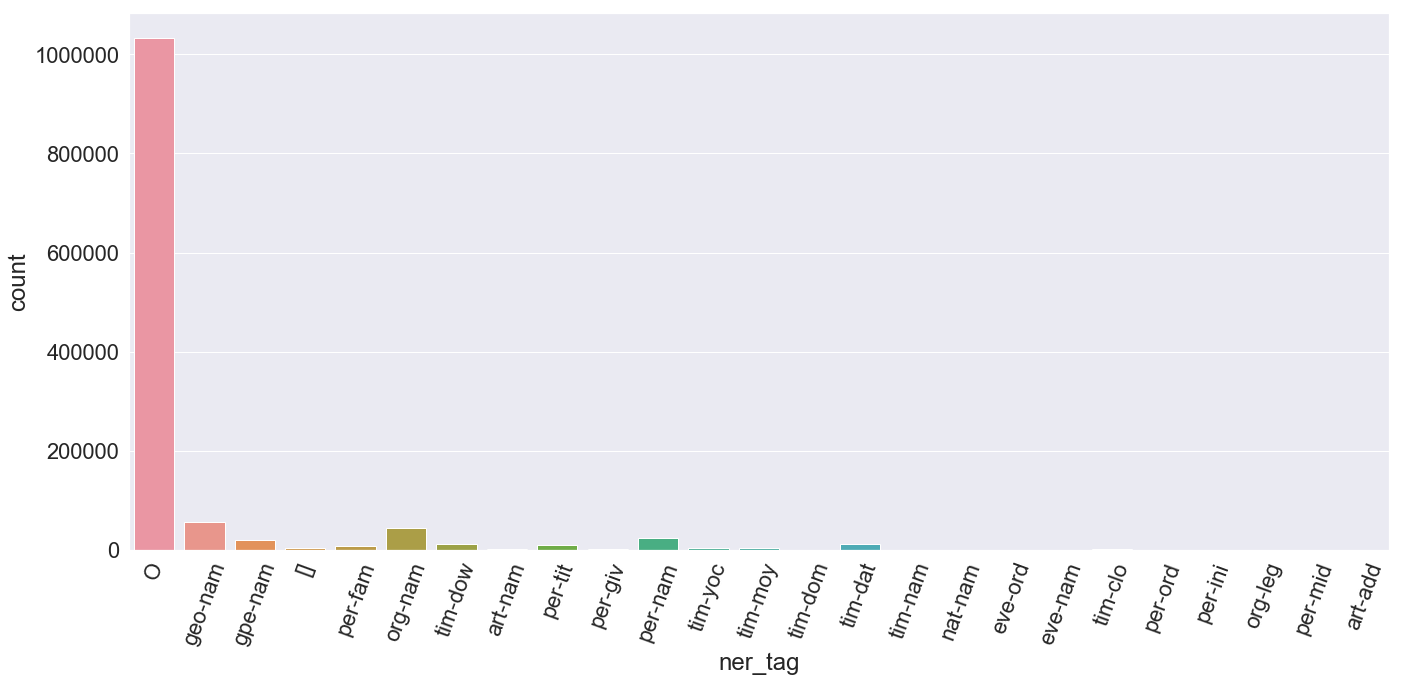

In [25]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot('ner_tag', data=tagged_texts_as_pd)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

Too many 'O' tags.

Let's try to build a distribution without them:

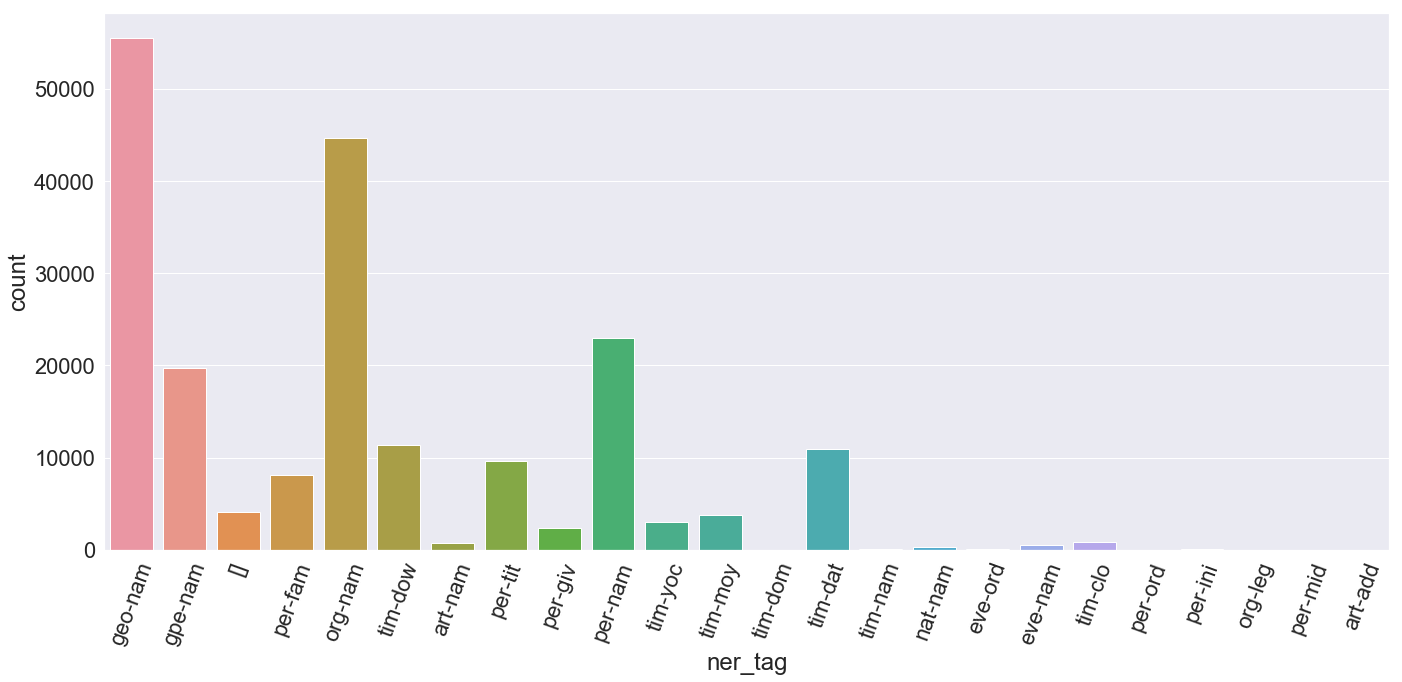

In [26]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot('ner_tag', data=tagged_texts_as_pd[tagged_texts_as_pd.ner_tag != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

What is the '[]'?

Let's take a look at words whith this tag:

In [27]:
tagged_texts_as_pd[tagged_texts_as_pd.ner_tag == '[]'].head()

,token,pos_tag,lemma,ner_tag
41,\tLQU\t,O,0,[]
46,\tRQU\t,O,0,[]
48,\tLQU\t,O,0,[]
53,\tLQU\t,O,0,[]
808,\tLQU\t,O,0,[]


In [28]:
tagged_texts_as_pd[tagged_texts_as_pd.ner_tag == '[]'].token.value_counts()

\tLQU\t    3025
\tRQU\t    1039
Name: token, dtype: int64

In [29]:
tagged_texts_as_pd[tagged_texts_as_pd.ner_tag == '[]'].pos_tag.value_counts()

O          3983
org-nam      37
per-nam      27
geo-nam      11
tim-dat       6
Name: pos_tag, dtype: int64

In [30]:
tagged_texts_as_pd[tagged_texts_as_pd.ner_tag == '[]'].lemma.value_counts()

0    4064
Name: lemma, dtype: int64

Well, seems like it's just some trash.

It will be dropped out of the data in filtration function.

now let's just get rid of it here:

In [31]:
tagged_texts_as_pd = tagged_texts_as_pd[tagged_texts_as_pd.ner_tag != '[]']

Let's also transform our tags into BIO-format:

In [32]:
tagged_texts_as_pd.ner_tag = iob3bio(tagged_texts_as_pd.ner_tag.values)

Okay, hot does it look like now:

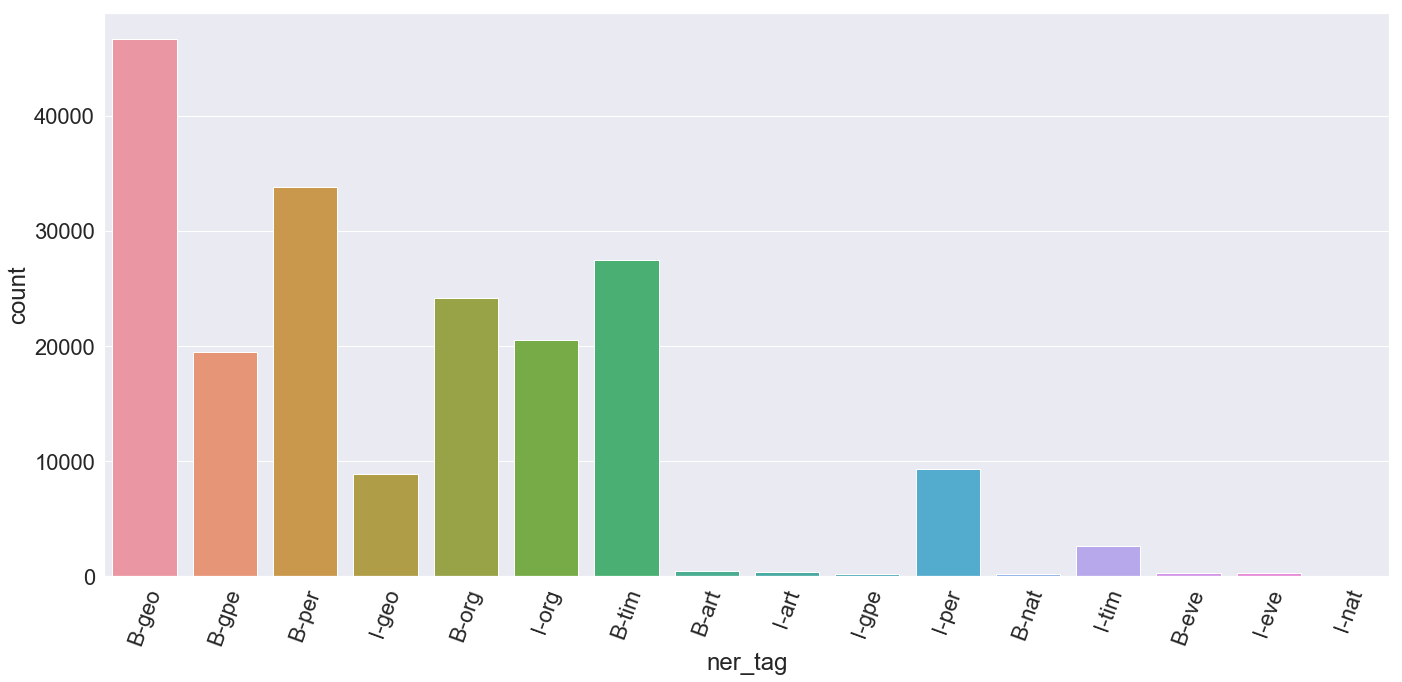

In [33]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot('ner_tag', data=tagged_texts_as_pd[tagged_texts_as_pd.ner_tag != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

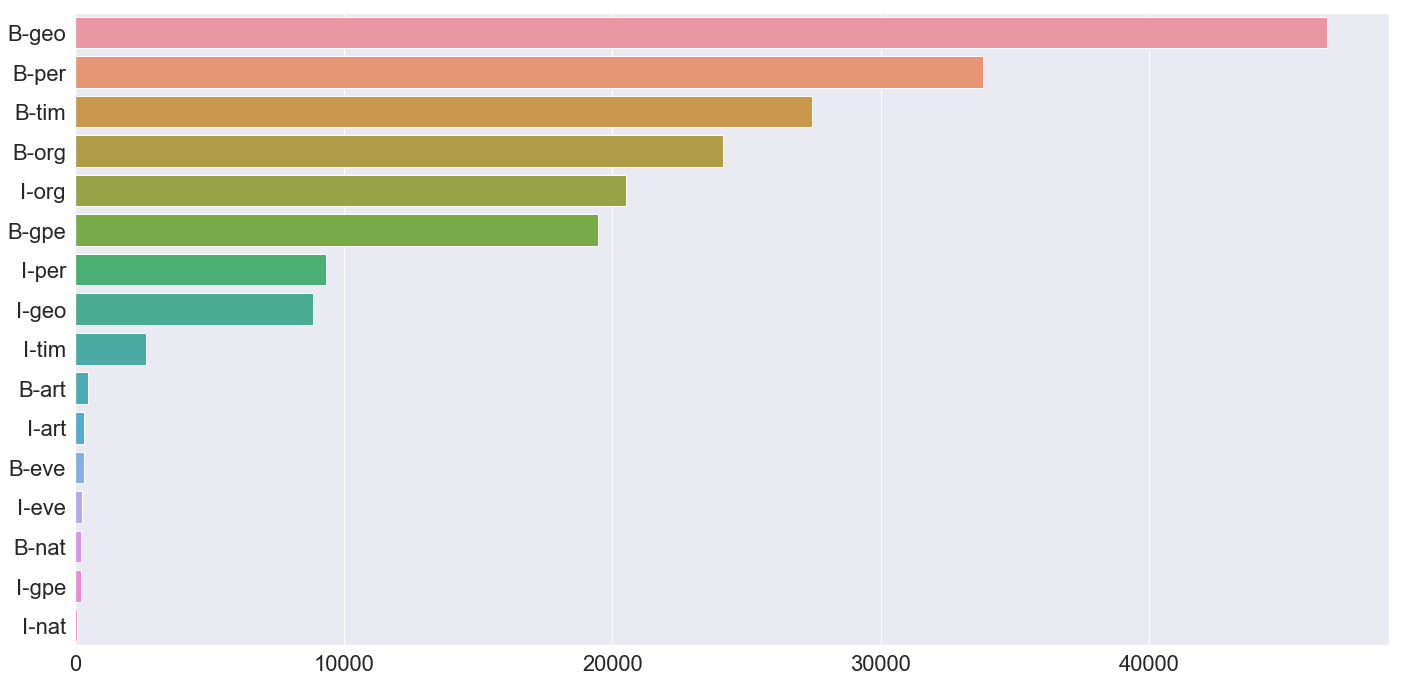

In [34]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
sns.barplot(
    x=tagged_texts_as_pd[tagged_texts_as_pd.ner_tag != 'O'].ner_tag.value_counts().values,
    y=tagged_texts_as_pd[tagged_texts_as_pd.ner_tag != 'O'].ner_tag.value_counts().index,
    orient='h'
)
plt.tight_layout()
plt.show()

That looks pretty much better.

now let's look at tags with low number of words:

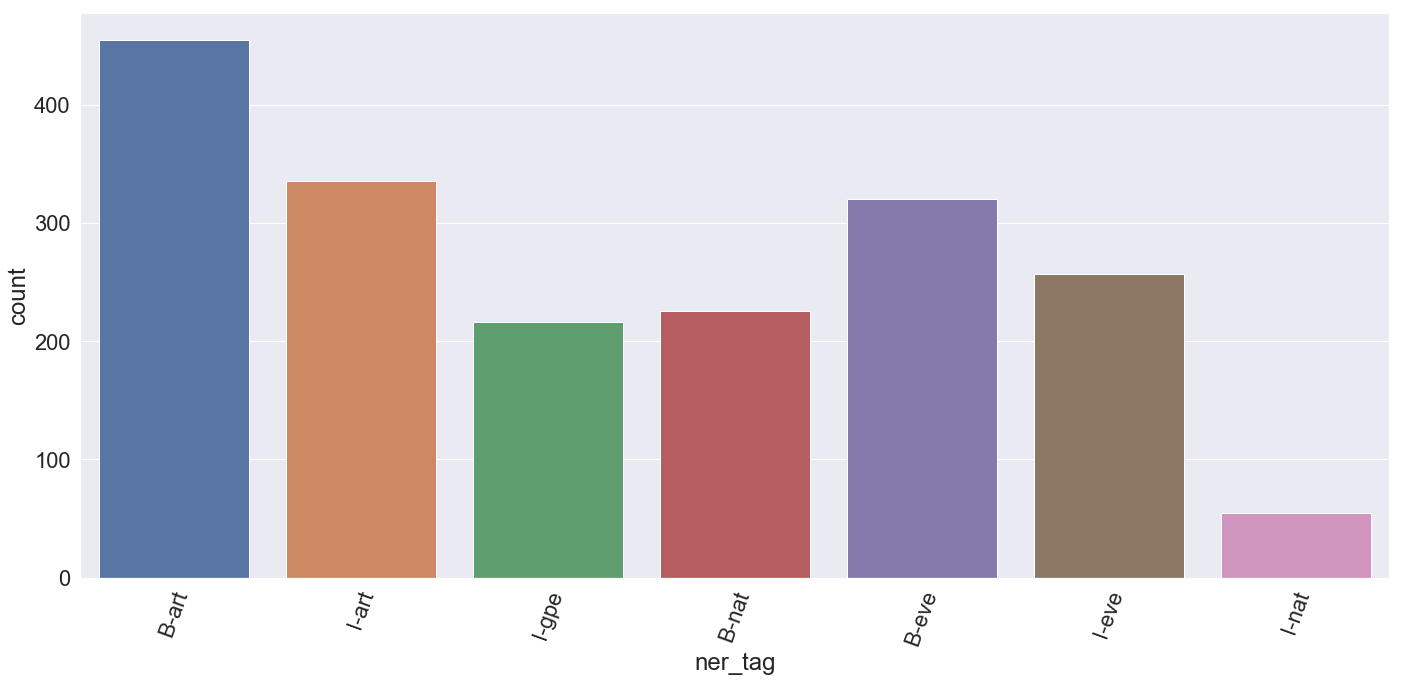

In [35]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot('ner_tag', data=tagged_texts_as_pd[tagged_texts_as_pd.ner_tag.isin(['B-art', 'I-art', 'I-gpe', 'B-nat', 'B-eve', 'I-eve', 'I-nat'])])
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

As it can be seen there is not so much words with these tags.

Also we can notice that the number or GPE-entities composed from several words is very small.

# Tags count per each word

Here the idea is to look at how many tags can be assigned to some particular word.

In [36]:
tags_count_per_word_distribution = tagged_texts_as_pd.groupby('lemma')['ner_tag'].agg(lambda x: list(set(x))).reset_index().rename({'ner_tag': 'tags_list'}, axis=1)

In [37]:
tags_count_per_word_distribution['tags_count'] = tags_count_per_word_distribution.tags_list.apply(len)

In [38]:
tags_count_per_word_distribution.sort_values(by='tags_count', ascending=False).head(20)

,lemma,tags_list,tags_count
10322,france,"[I-geo, B-per, B-org, B-gpe, I-eve, I-art, O, ...",11
24471,the,"[I-geo, B-tim, B-org, O, I-art, B-eve, I-eve, ...",11
17879,of,"[I-gpe, B-tim, I-geo, O, I-art, I-eve, B-org, ...",11
9044,england,"[I-geo, B-tim, B-per, B-gpe, B-org, I-eve, I-o...",10
17984,olympics,"[B-tim, I-geo, O, B-eve, I-eve, B-org, I-tim, ...",10
17356,new,"[I-geo, B-tim, B-org, O, B-eve, B-gpe, I-art, ...",10
23412,state,"[I-gpe, I-geo, B-per, B-org, O, I-tim, B-geo, ...",10
14,-,"[I-geo, B-tim, B-per, B-org, O, I-art, I-tim, ...",10
18448,pakistan,"[I-geo, B-per, B-org, B-gpe, O, B-eve, I-tim, ...",10
15319,madrid,"[B-tim, I-geo, B-eve, O, B-org, I-tim, B-geo, ...",9


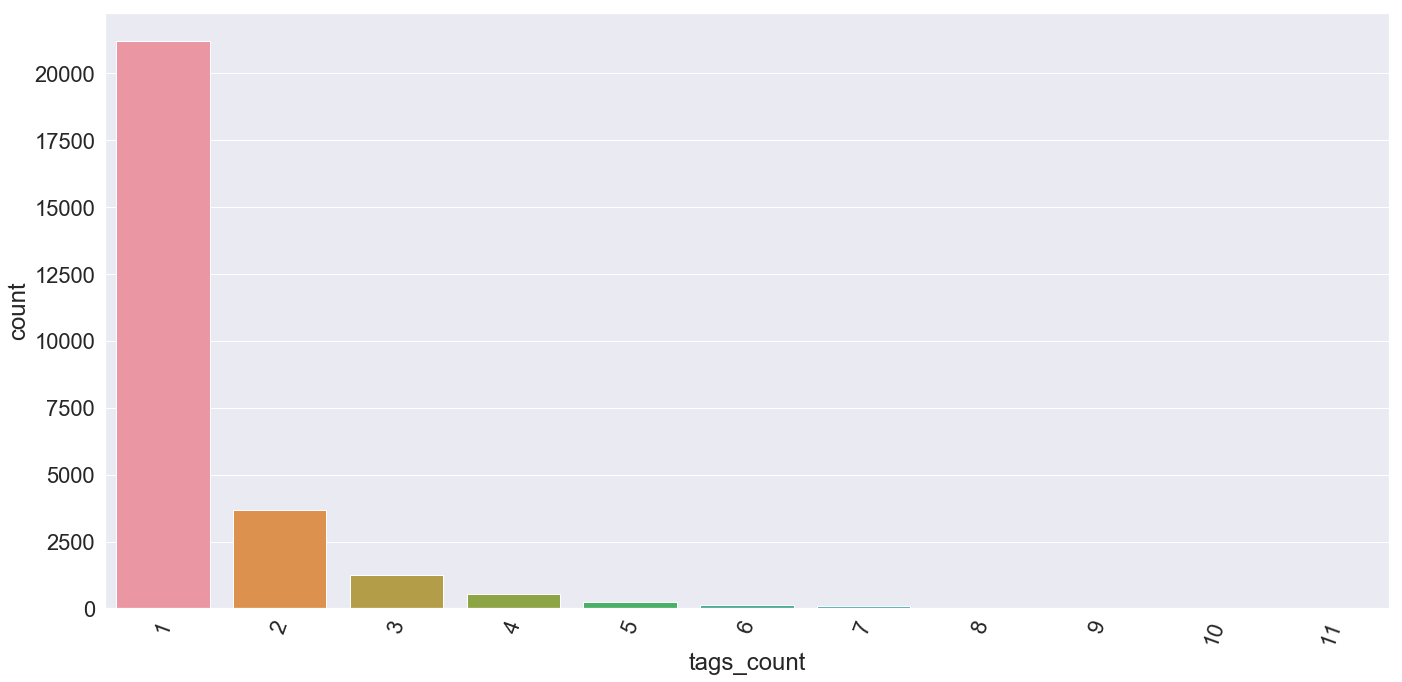

In [39]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot('tags_count', data=tags_count_per_word_distribution)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

As we can see the majority of words has only one tag.

But there are also others, let's look at them a bit closer:

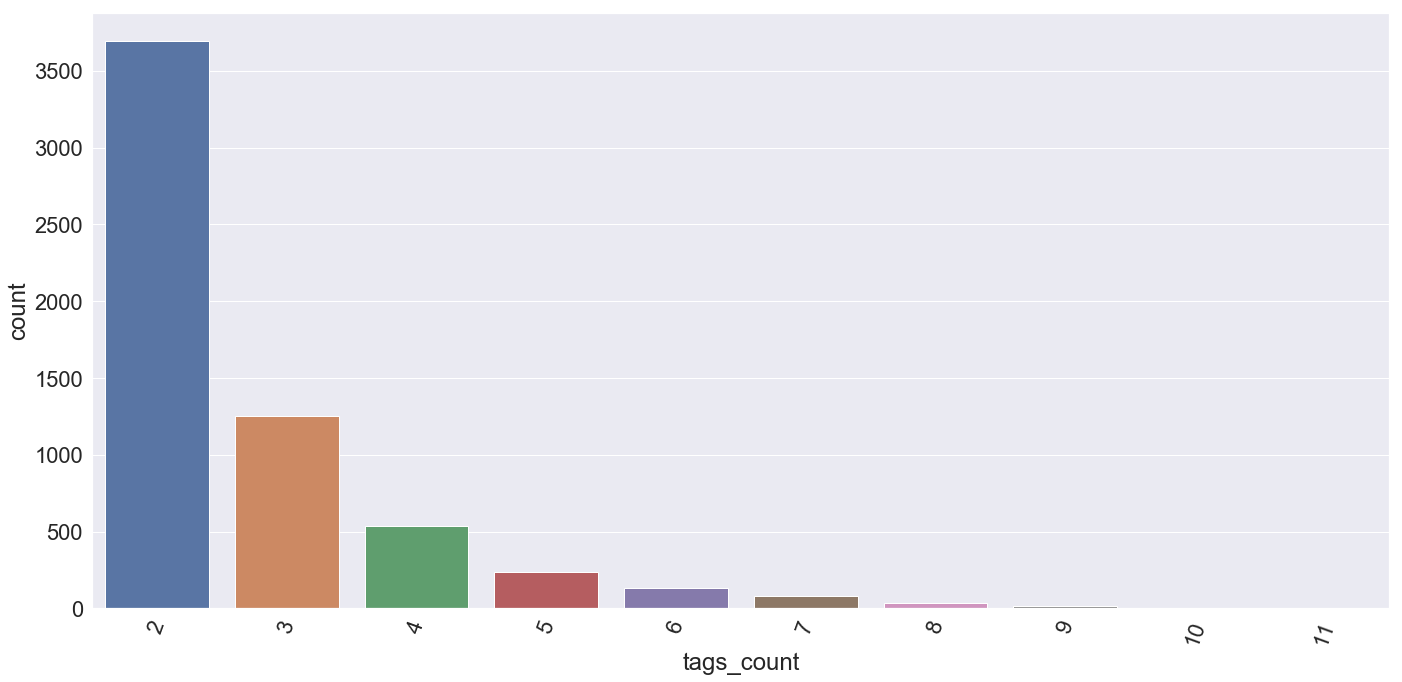

In [40]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot('tags_count', data=tags_count_per_word_distribution[tags_count_per_word_distribution.tags_count != 1])
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

So I guess depending on the context some particular word can be either 'O' or some tag.

Also there are lots of stop-words which can be a part on some NER-tag composed from several words ("Republic of Korea", "The lonely mountain" etc.)

Let's trey to take a look at those lemmas that are not in nltk stop-words list:

In [41]:
stopWords = set(stopwords.words('english'))

In [42]:
tags_count_per_word_distribution = tagged_texts_as_pd[
    (~tagged_texts_as_pd.lemma.isin(stopWords))
].groupby('lemma')['ner_tag'].agg(lambda x: list(set(x))).reset_index().rename({'ner_tag': 'tags_list'}, axis=1)

In [43]:
tags_count_per_word_distribution['tags_count'] = tags_count_per_word_distribution.tags_list.apply(len)

In [44]:
tags_count_per_word_distribution.sort_values(by='tags_count', ascending=False).head(20)

,lemma,tags_list,tags_count
10290,france,"[I-geo, B-per, B-org, B-gpe, I-eve, I-art, O, ...",11
14,-,"[I-geo, B-tim, B-per, B-org, O, I-art, I-tim, ...",10
9014,england,"[I-geo, B-tim, B-per, B-gpe, B-org, I-eve, I-o...",10
23329,state,"[I-gpe, I-geo, B-per, B-org, O, I-tim, B-geo, ...",10
18372,pakistan,"[I-geo, B-per, B-org, B-gpe, O, B-eve, I-tim, ...",10
17918,olympics,"[B-tim, I-geo, O, B-eve, I-eve, B-org, I-tim, ...",10
17296,new,"[I-geo, B-tim, B-org, O, B-eve, B-gpe, I-art, ...",10
17085,national,"[I-geo, B-per, B-org, O, B-eve, I-eve, B-geo, ...",9
25029,turkey,"[I-geo, B-tim, B-org, O, B-gpe, I-tim, B-geo, ...",9
16847,muslim,"[I-geo, B-tim, B-per, O, B-org, I-tim, B-geo, ...",9


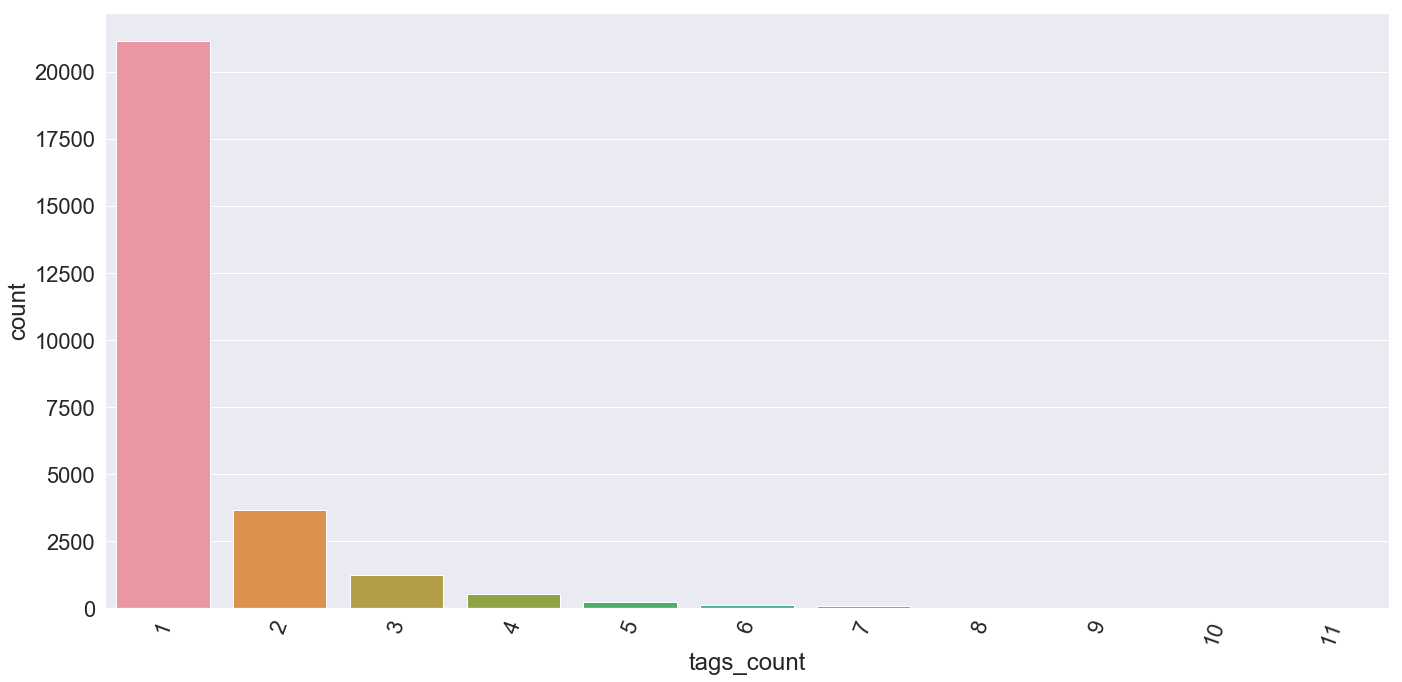

In [45]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot('tags_count', data=tags_count_per_word_distribution)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

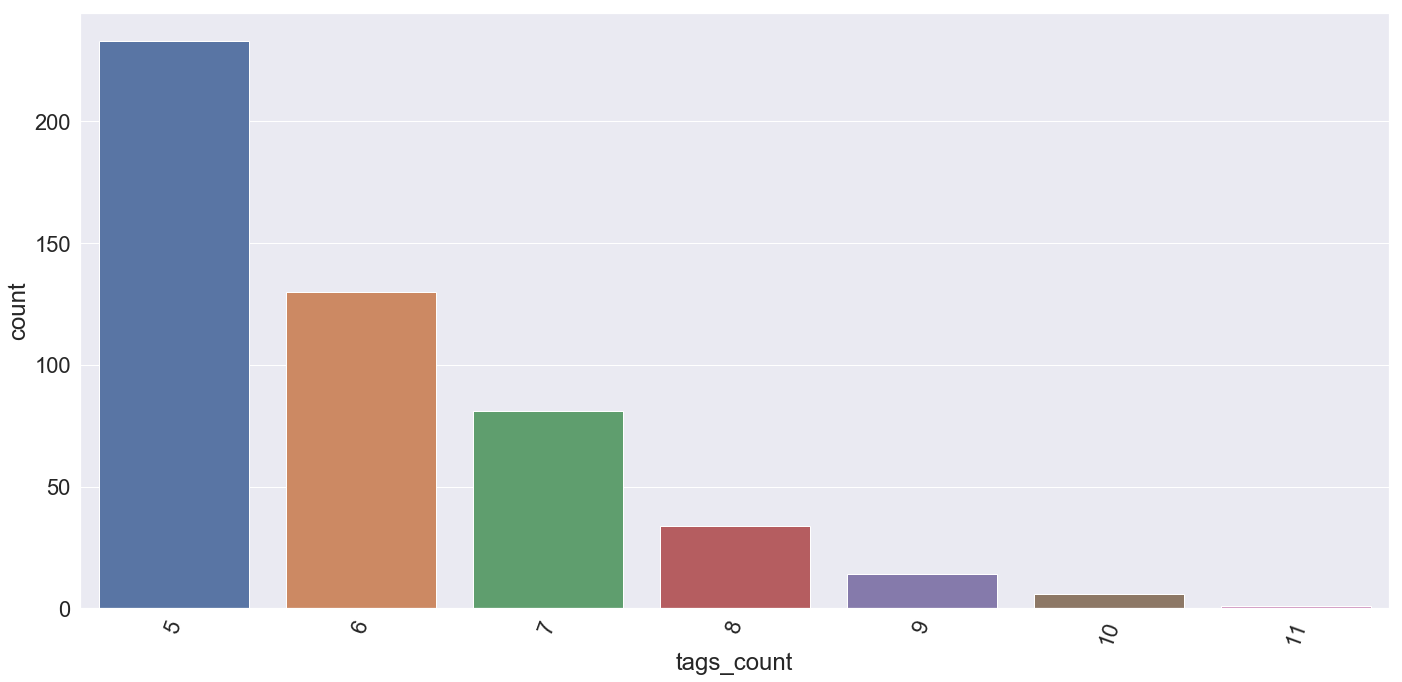

In [46]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot('tags_count', data=tags_count_per_word_distribution[tags_count_per_word_distribution.tags_count >= 5])
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

# Lemma length distribution

Let's lookt at how word lengths are distributed:

In [47]:
tagged_texts_as_pd['lemma_length'] = tagged_texts_as_pd.lemma.apply(len)

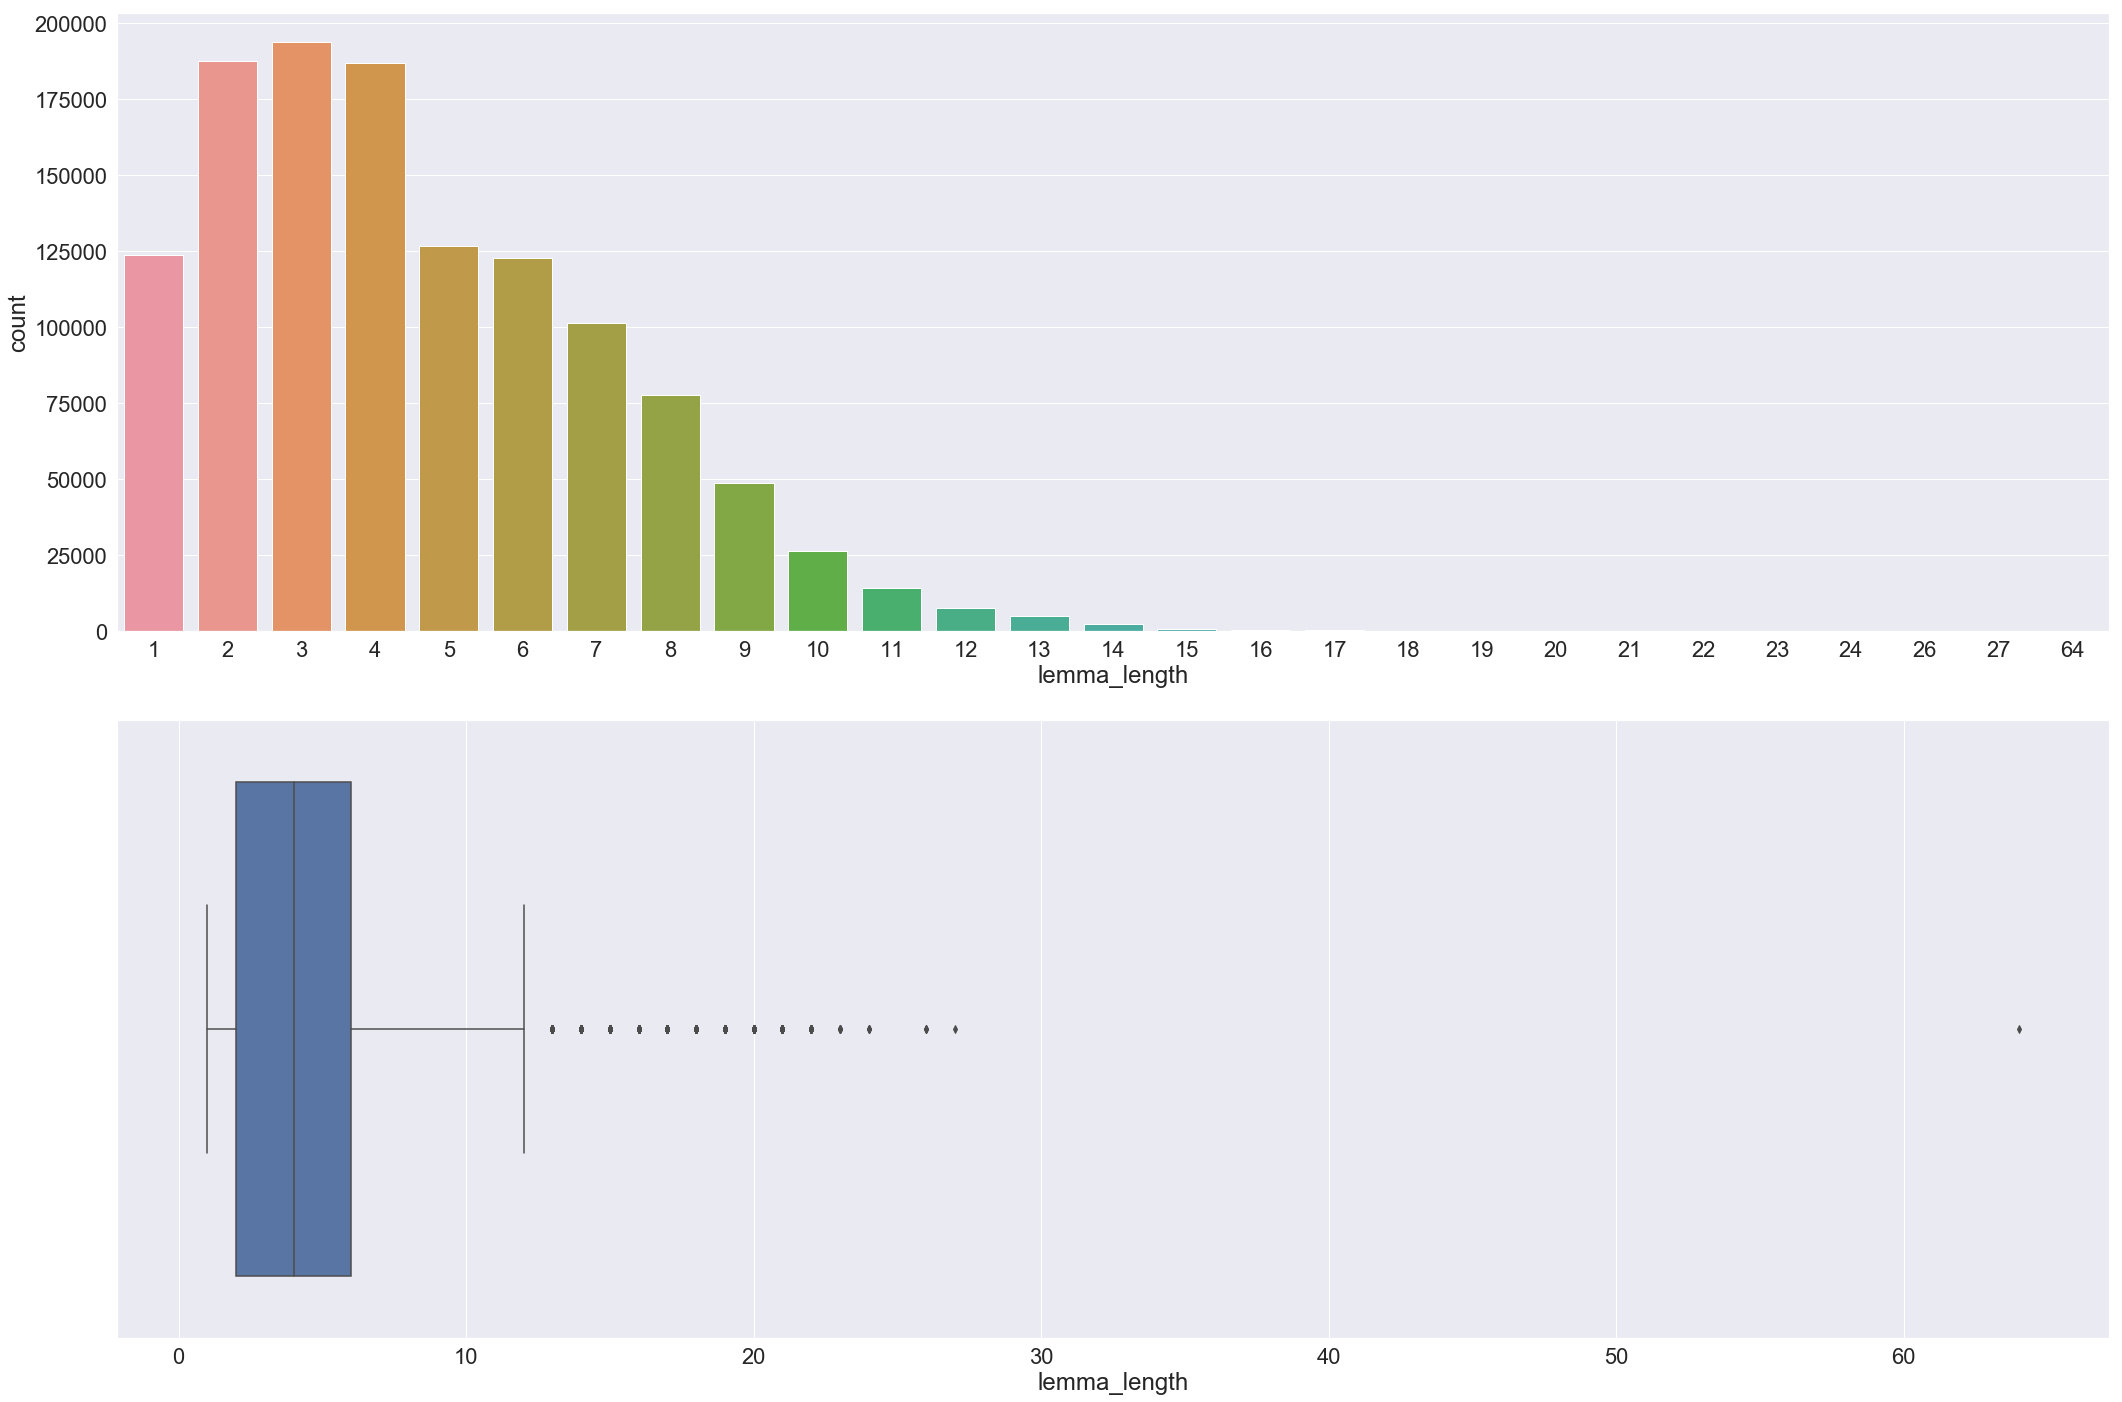

In [48]:
sns.set(font_scale=2)
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(30, 20))
sns.countplot('lemma_length', data=tagged_texts_as_pd, ax=ax1)
sns.boxplot('lemma_length', data=tagged_texts_as_pd, ax=ax2, orient='h')
plt.tight_layout()
plt.show()

The main majority of words has length between 3 and 7 letters and there are obviously several outliers.

Let's look at them closer:

In [49]:
tagged_texts_as_pd.sort_values(by='lemma_length', ascending=False).head(30)

,token,pos_tag,lemma,ner_tag,lemma_length
181246,https://www.celebritiesforcharity.org/raffles/...,NNP,https://www.celebritiesforcharity.org/raffles/...,B-geo,64
145539,cricketer-turned-politician,JJ,cricketer-turned-politician,O,27
2895,internationally-recognized,JJ,internationally-recognized,O,26
912265,internationally-recognized,JJ,internationally-recognized,O,26
811960,internationally-recognized,JJ,internationally-recognized,O,26
491926,environmentally-friendly,RB,environmentally-friendly,O,24
238916,environmentally-friendly,JJ,environmentally-friendly,O,24
216726,internationally-brokered,JJ,internationally-brokered,O,24
192280,Petropavlosk-Kamchatskii,NNP,petropavlosk-kamchatskii,B-geo,24
438133,Congressional-Executive,JJ,congressional-executive,B-org,23


Ok, and how do short words look like?

In [50]:
tagged_texts_as_pd.sort_values(by='lemma_length', ascending=True).head(60)

,token,pos_tag,lemma,ner_tag,lemma_length
1231278,.,.,.,O,1
1022432,",",",",",",O,1
318994,.,.,.,O,1
1022420,.,.,.,O,1
319026,',POS,',O,1
319029,a,DT,a,O,1
319032,.,.,.,O,1
319041,.,.,.,O,1
1022379,.,.,.,O,1
1022375,",",",",",",O,1


Well there are obviously lots of stop-words which will bring some noise in the data.



# Stop-words and punctuation

In [51]:
stopWords = set(stopwords.words('english'))

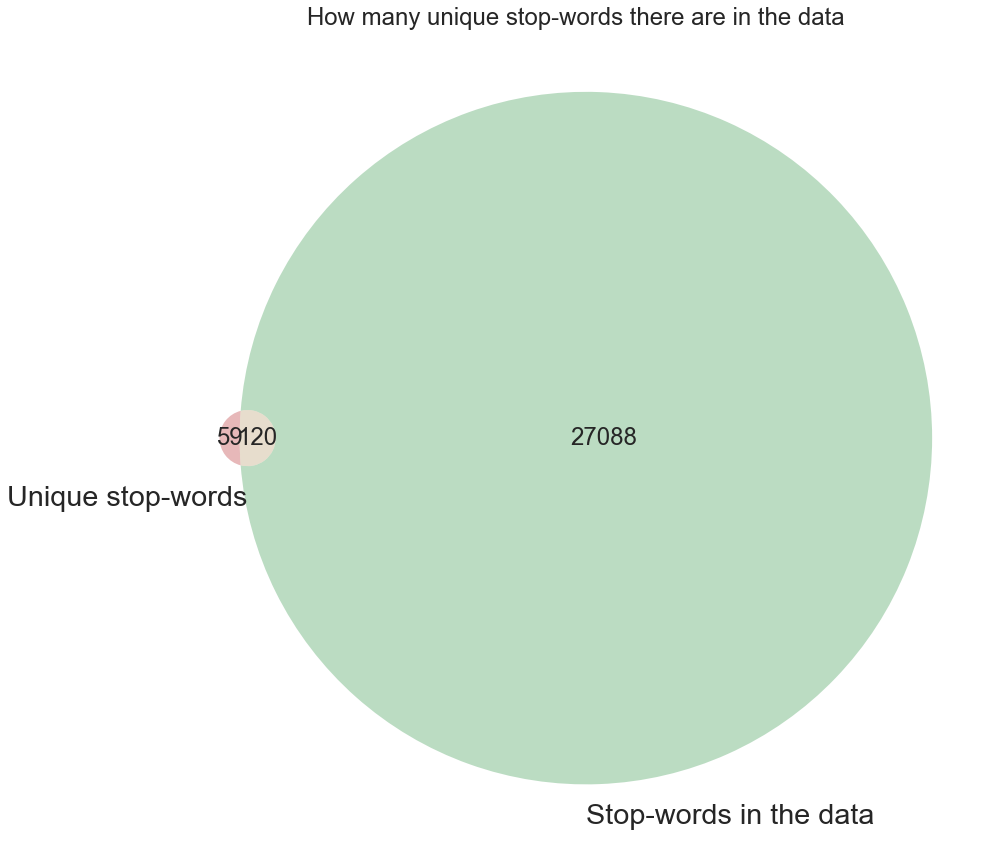

In [52]:
plt.figure(figsize=(15, 15))
venn2(subsets=[stopWords, set(tagged_texts_as_pd.lemma)], set_labels=('Unique stop-words', 'Stop-words in the data'))
plt.title('How many unique stop-words there are in the data')
plt.show()

Let's remove them and see if the NER-tag distribution will change:

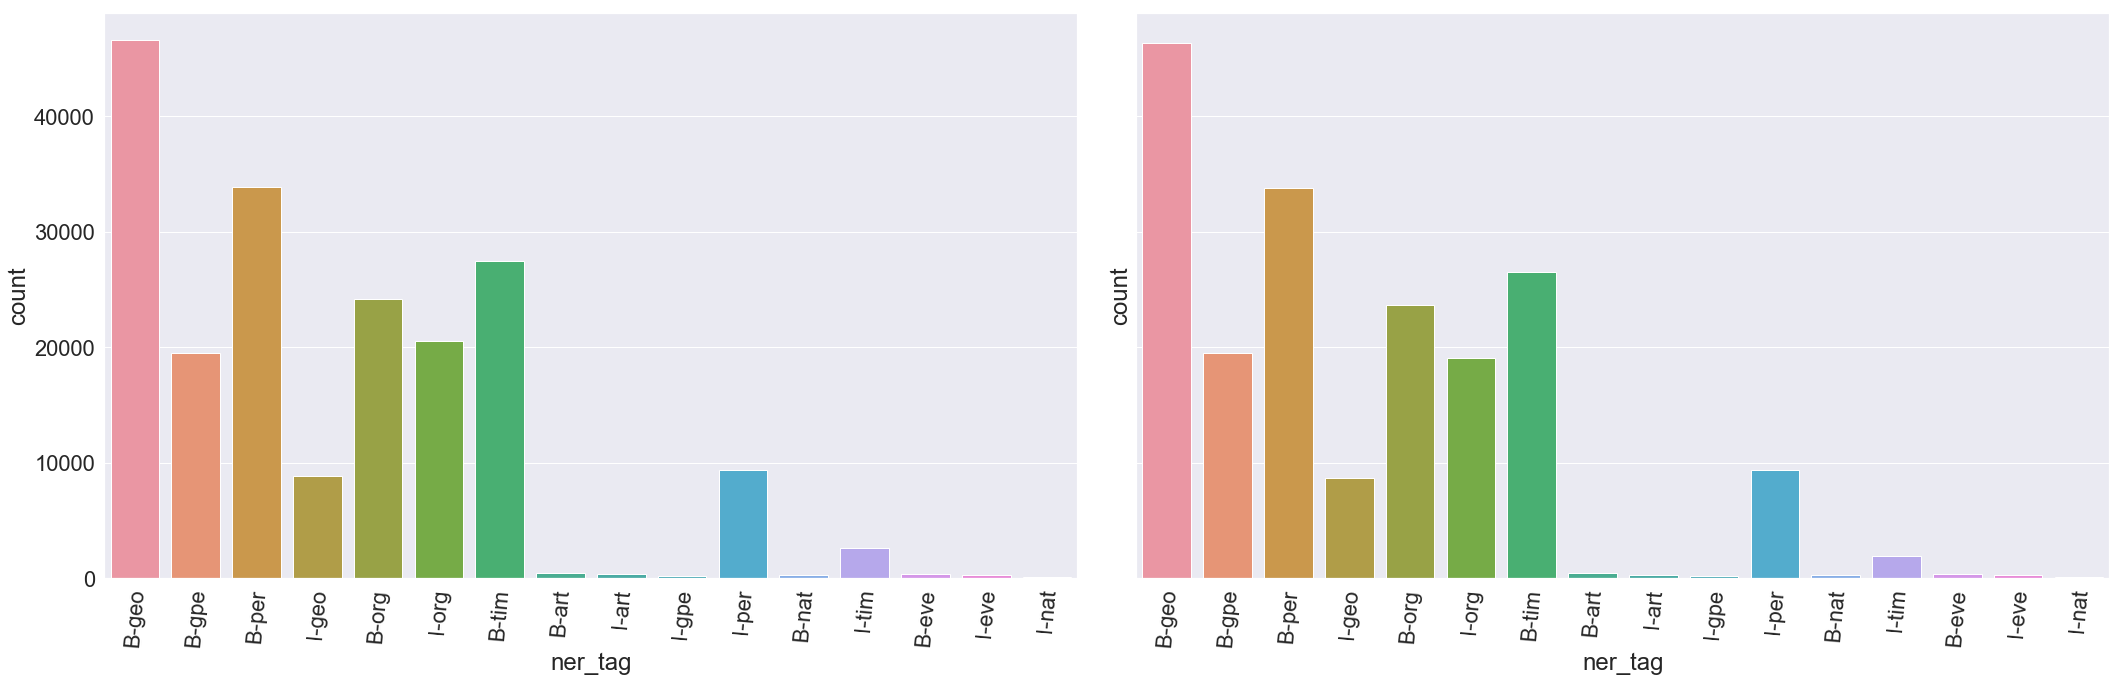

In [53]:
sns.set(font_scale=2)
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10), sharey=True)
sns.countplot('ner_tag', data=tagged_texts_as_pd[tagged_texts_as_pd.ner_tag != 'O'], ax=ax1)
sns.countplot('ner_tag', data=tagged_texts_as_pd[(~tagged_texts_as_pd.lemma.isin(stopWords)) & (tagged_texts_as_pd.ner_tag != 'O')], ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=85, ha="center")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=85, ha="center")
plt.tight_layout()
plt.show()

We can see from these plots that the distribution has not dramatically changed.

How many words were deleted?

In [54]:
len(tagged_texts_as_pd) - len(tagged_texts_as_pd[(~tagged_texts_as_pd.lemma.isin(stopWords))])

406955

Wow!

So many words were deleted and yet the distribution of NER-tags stayed almost the same.

Looks like it was mostly "O"-tags (surprise-surprise, who would have thought!)))

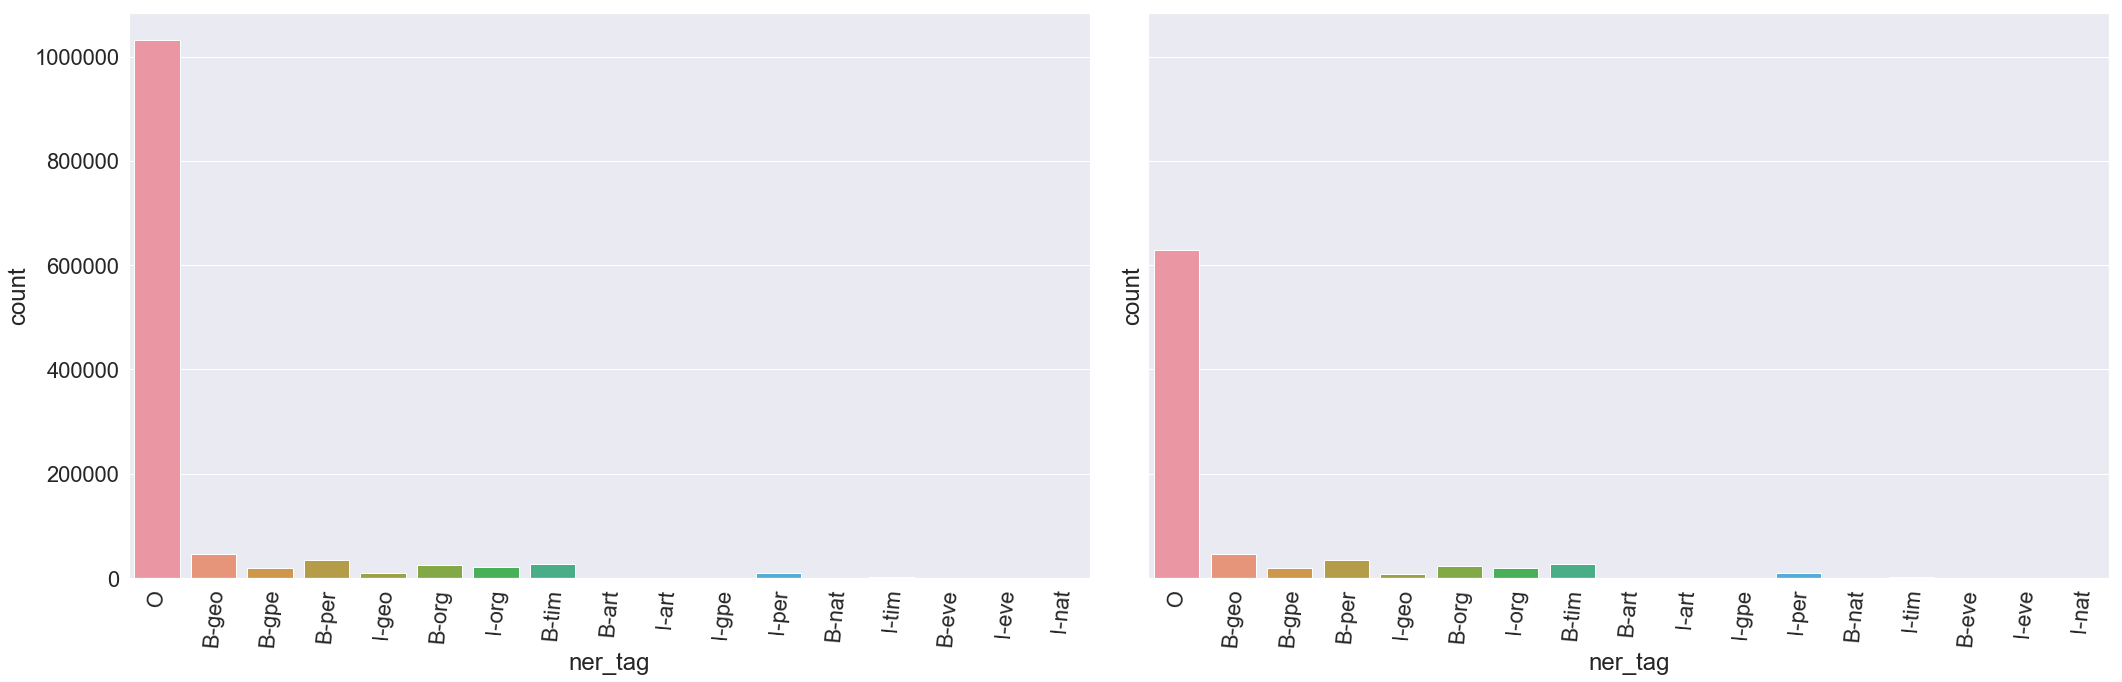

In [55]:
sns.set(font_scale=2)
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10), sharey=True)
sns.countplot('ner_tag', data=tagged_texts_as_pd, ax=ax1)
sns.countplot('ner_tag', data=tagged_texts_as_pd[~tagged_texts_as_pd.lemma.isin(stopWords)], ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=85, ha="center")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=85, ha="center")
plt.tight_layout()
plt.show()

And yep, it was mostly "O"-tags which can be seen from the difference in the two first columns of the plots.

# Token shape

Let's introduce new feature - word shape.

Here is the method to calculate it:

In [56]:
def wordshape(word):
    import re
    t1 = re.sub('[A-Z]', 'X', word)
    t2 = re.sub('[a-z]', 'x', t1)
    t3 = re.sub('[0-9]', 'd', t2)
    return t3

In [57]:
tagged_texts_as_pd['word_shape'] = tagged_texts_as_pd.token.apply(wordshape)

In [58]:
tagged_texts_as_pd.head(20)

,token,pos_tag,lemma,ner_tag,lemma_length,word_shape
0,Thousands,NNS,thousand,O,8,Xxxxxxxxx
1,of,IN,of,O,2,xx
2,demonstrators,NNS,demonstrator,O,12,xxxxxxxxxxxxx
3,have,VBP,have,O,4,xxxx
4,marched,VBN,march,O,5,xxxxxxx
5,through,IN,through,O,7,xxxxxxx
6,London,NNP,london,B-geo,6,Xxxxxx
7,to,TO,to,O,2,xx
8,protest,VB,protest,O,7,xxxxxxx
9,the,DT,the,O,3,xxx


In [59]:
tagged_texts_as_pd.word_shape.value_counts()

xxx                        164427
xx                         139378
xxxx                       131151
xxxxx                       85444
xxxxxx                      81815
xxxxxxx                     78572
xxxxxxxx                    60657
.                           56739
xxxxxxxxx                   48462
Xxxxxx                      37369
,                           35772
Xxxxx                       33223
Xxxxxxx                     32046
xxxxxxxxxx                  26276
x                           23793
Xxxxxxxx                    22289
Xxxx                        21397
Xxx                         20758
Xxxxxxxxx                   16982
'x                          13351
xxxxxxxxxxx                 11742
Xx                           7063
xxxxxxxxxxxx                 6740
Xxxxxxxxxx                   6656
X.X.                         6587
dd                           6524
Xxxxxxxxxxx                  5200
Xx.                          4311
xxxxxxxxxxxxx                3785
dddd          

# Is the token titled or not?

In [60]:
tagged_texts_as_pd['is_title'] = tagged_texts_as_pd.token.apply(lambda x: int(str(x).istitle()))

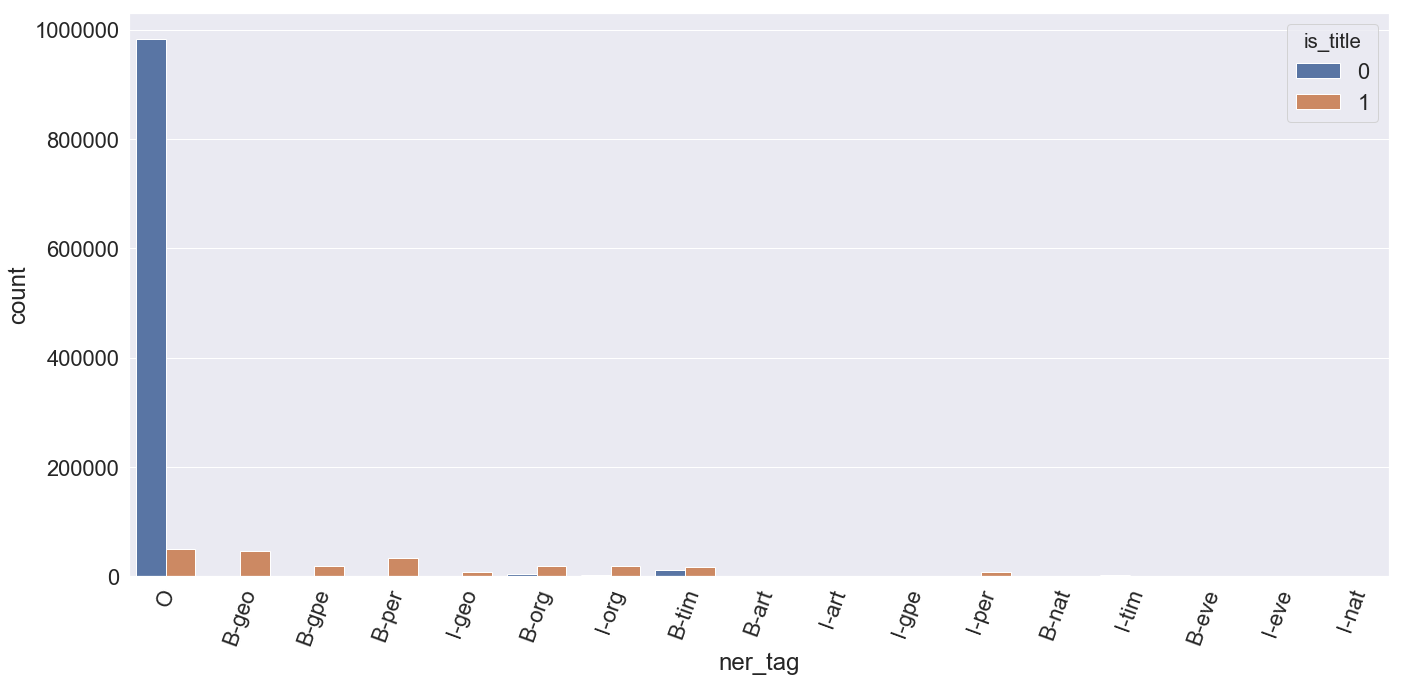

In [61]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot('ner_tag', data=tagged_texts_as_pd, hue='is_title')
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

Ok, get it most (or even almost all) tokens which are not titled have 'O'-tag.

What about the rest?

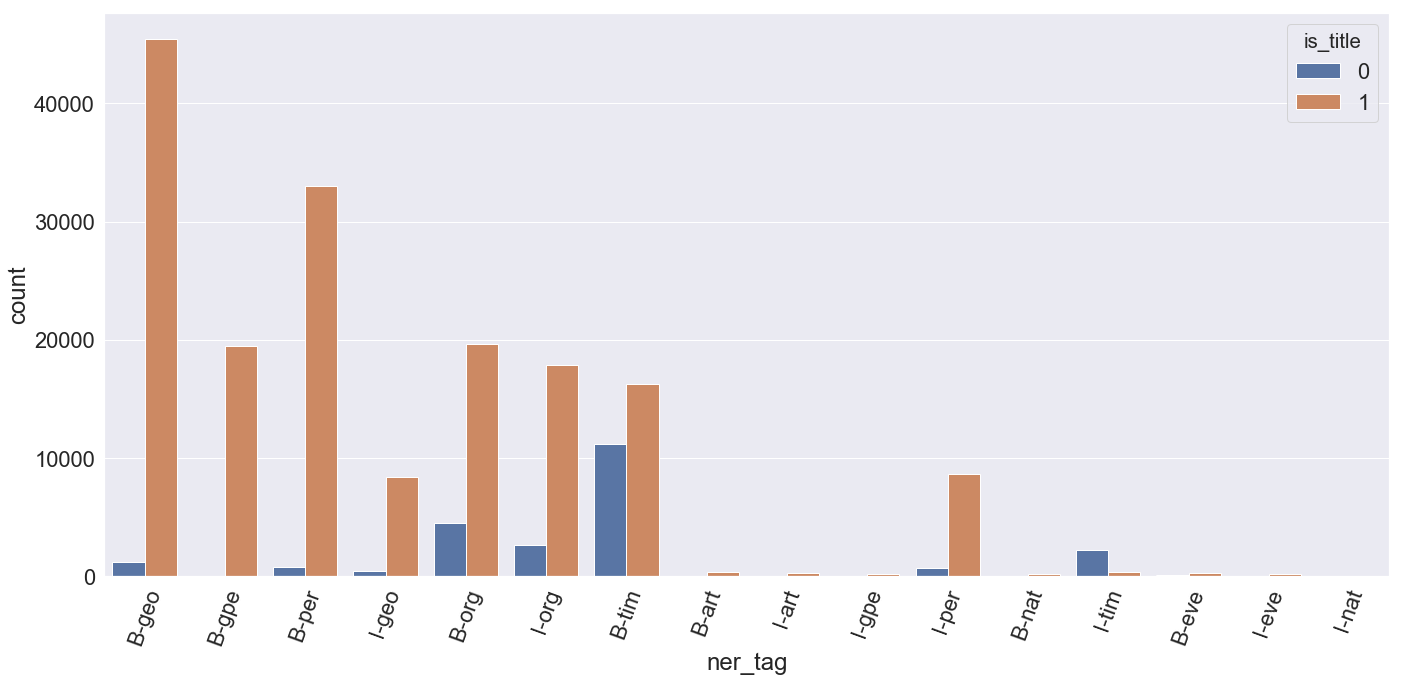

In [62]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot('ner_tag', data=tagged_texts_as_pd[tagged_texts_as_pd.ner_tag != 'O'], hue='is_title')
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

This plot shows more clear that there is only 'I-tim' tag which have more untitled words than titled ones.

Let's also look at very rare tags:

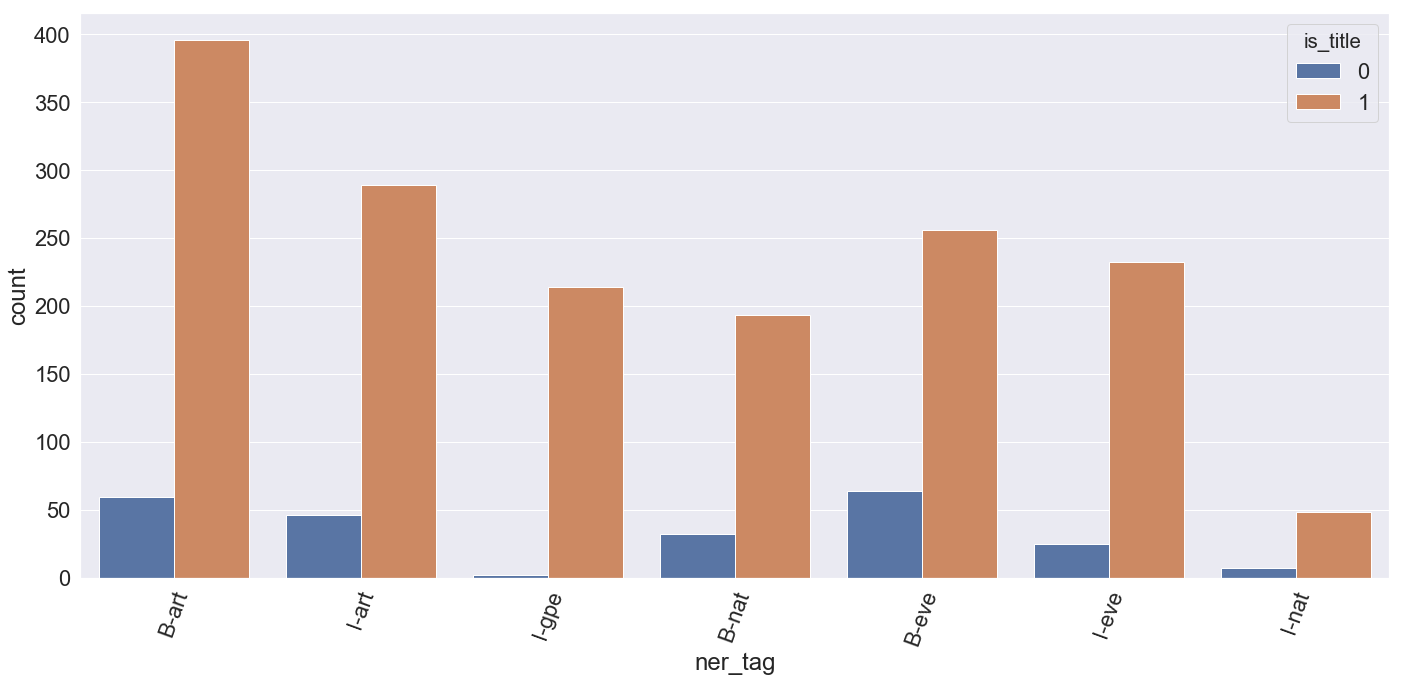

In [63]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot('ner_tag', data=tagged_texts_as_pd[tagged_texts_as_pd.ner_tag.isin(['B-eve', 'I-eve', 'I-gpe', 'B-art', 'I-art', 'B-nat', 'I-nat'])], hue='is_title')
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

And yep, still the same.

Majority of words with NER-tags are titled.

Let's also try to look at them without stop-words:

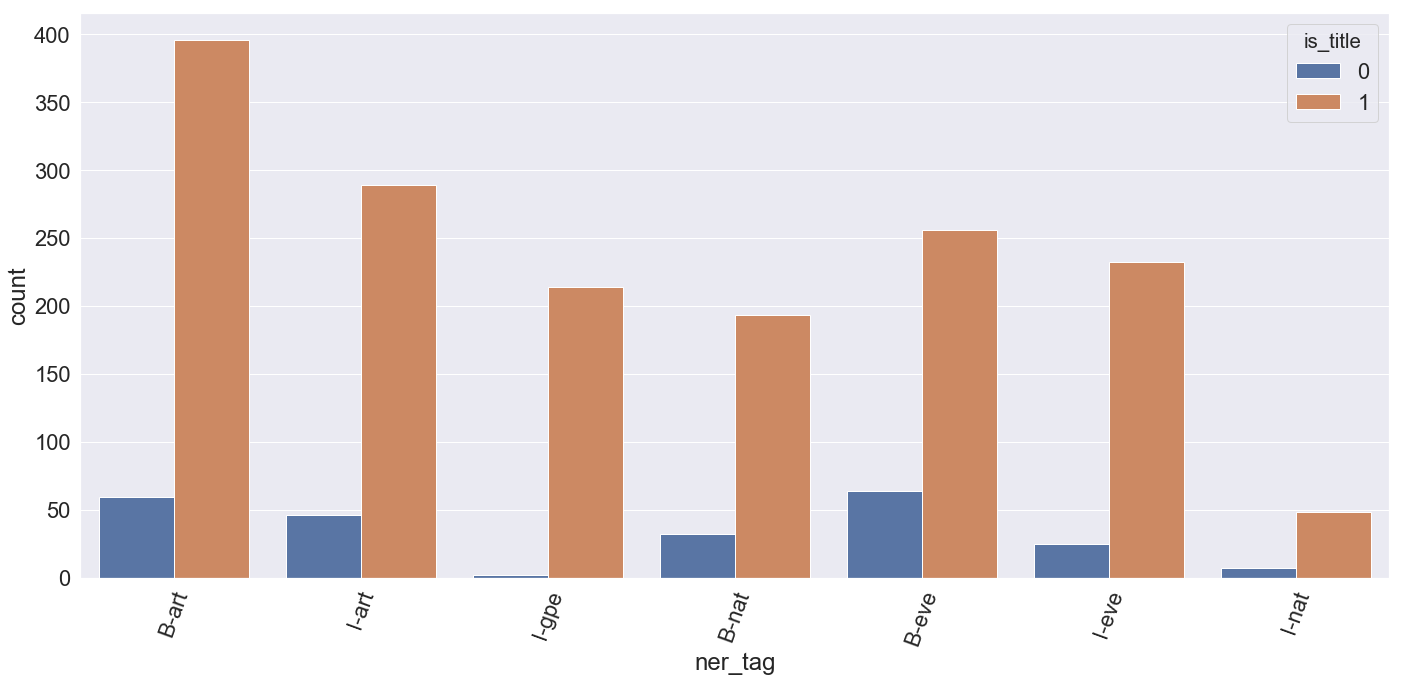

In [64]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot(
    'ner_tag',
    data=tagged_texts_as_pd[
        (tagged_texts_as_pd.ner_tag.isin(['B-eve', 'I-eve', 'I-gpe', 'B-art', 'I-art', 'B-nat', 'I-nat'])) & (~tagged_texts_as_pd.ner_tag.isin(stopWords))
    ],
    hue='is_title'
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

Not so much of a change.

# Is the token purely alphabetic or not?

In [65]:
tagged_texts_as_pd['purely_alphabetic'] = tagged_texts_as_pd.token.apply(lambda x: int(str(x).isalpha()))

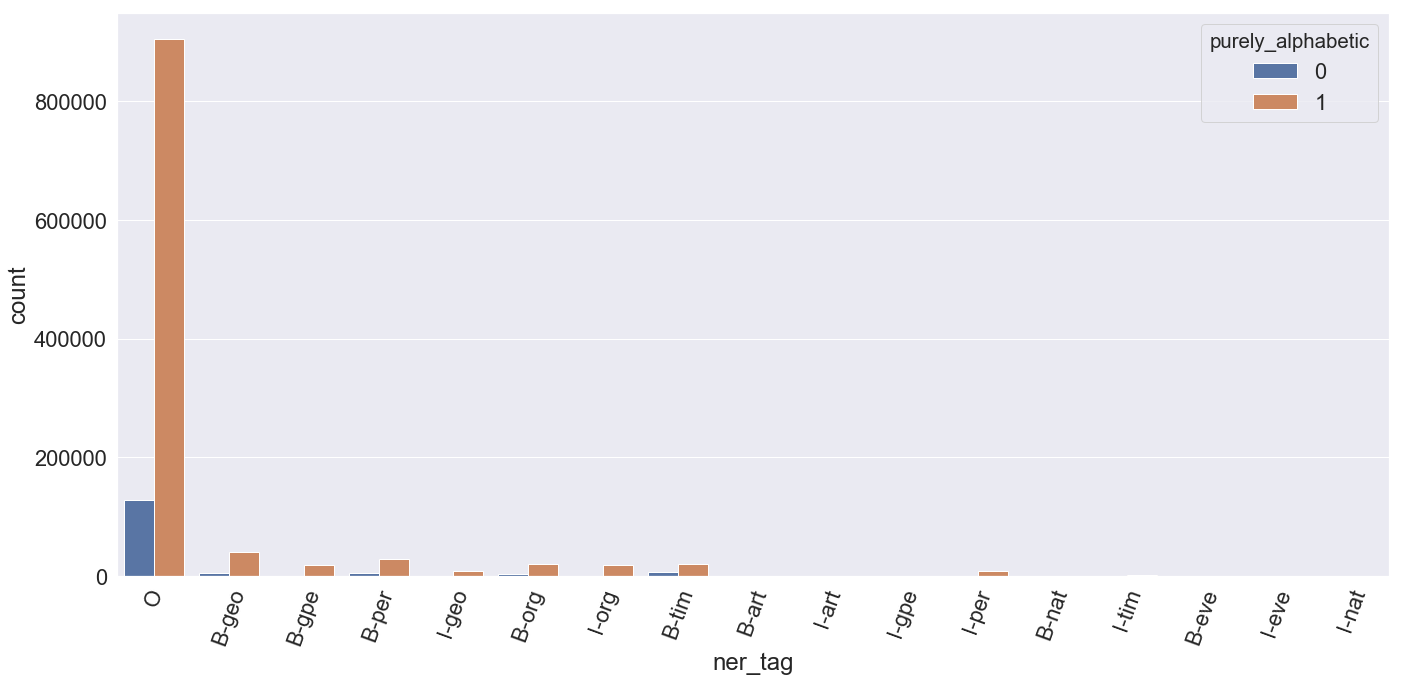

In [66]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot('ner_tag', data=tagged_texts_as_pd, hue='purely_alphabetic')
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

Interesting.

Almost all tokens are purely alphabetic.

Let's look a bit closer:

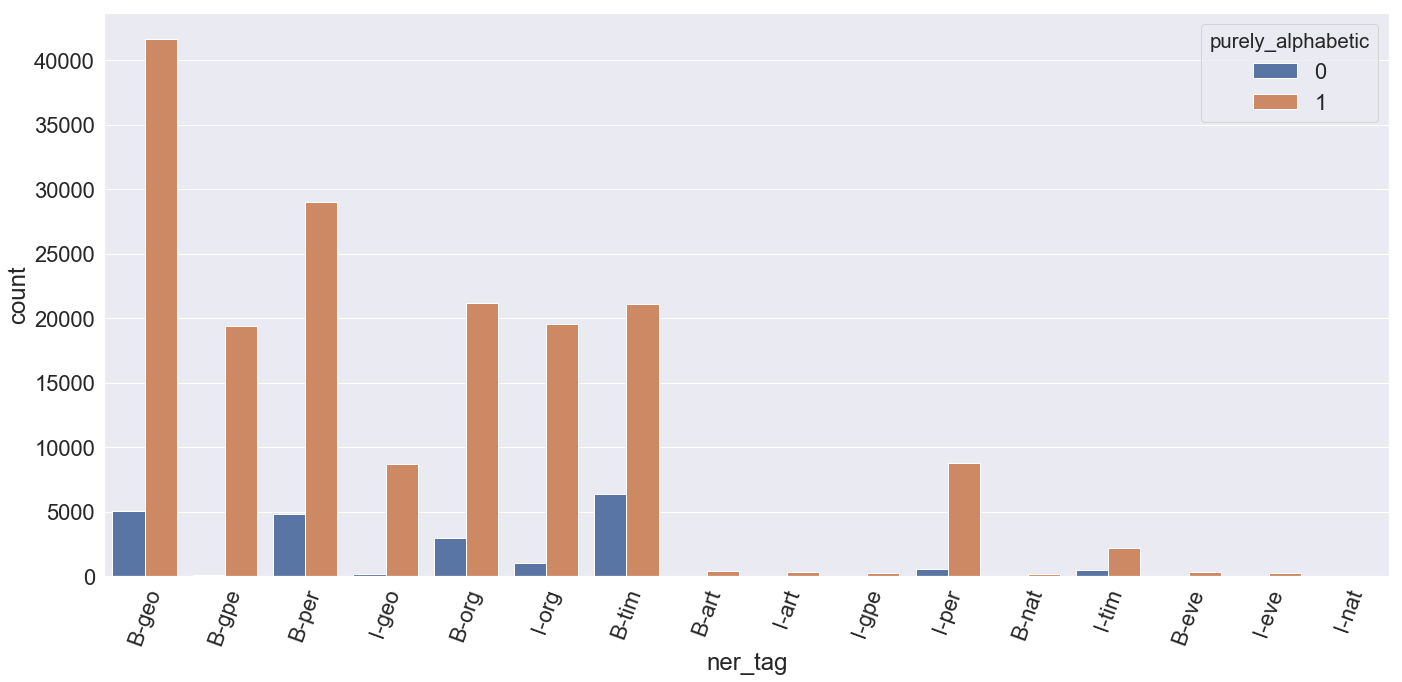

In [67]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot('ner_tag', data=tagged_texts_as_pd[tagged_texts_as_pd.ner_tag != 'O'], hue='purely_alphabetic')
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

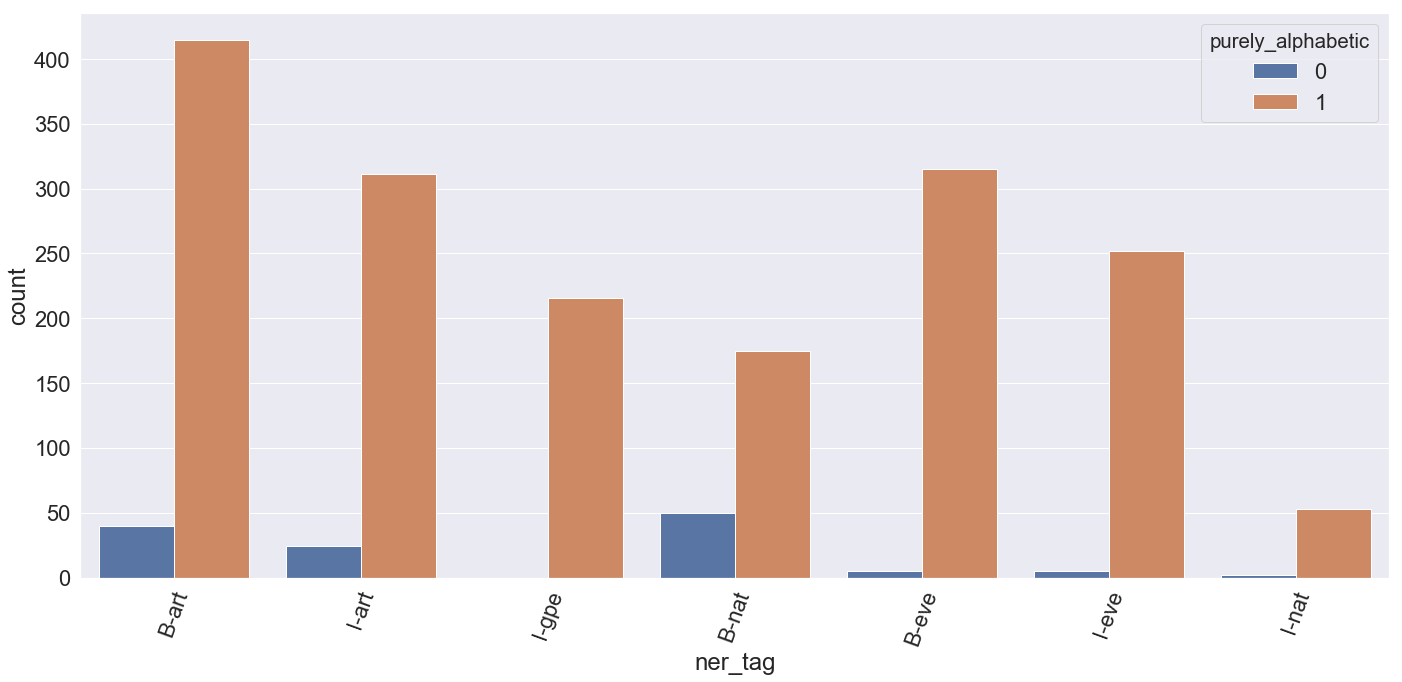

In [68]:
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
ax = sns.countplot(
    'ner_tag',
    data=tagged_texts_as_pd[
        (tagged_texts_as_pd.ner_tag.isin(['B-eve', 'I-eve', 'I-gpe', 'B-art', 'I-art', 'B-nat', 'I-nat'])) & (~tagged_texts_as_pd.ner_tag.isin(stopWords))
    ],
    hue='purely_alphabetic'
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="center")
plt.tight_layout()
plt.show()

Nothing has changed.

# Calculate some statistics

In [72]:
collapsed_columns = ['art', 'eve', 'geo', 'gpe', 'nat', 'org', 'per', 'tim']

In [79]:
ner_pos_contingency_table = pd.pivot_table(
    data=tagged_texts_as_pd[tagged_texts_as_pd.ner_tag != 'O'],
    fill_value=0,
    values='token',
    index='pos_tag',
    columns='ner_tag',
    aggfunc=len
)

In [80]:
for column in collapsed_columns:
    ner_pos_contingency_table[
        column
    ] = ner_pos_contingency_table[
        'B-{}'.format(column)
    ] + ner_pos_contingency_table[
        'I-{}'.format(column)
    ]

In [74]:
ner_pos_contingency_table[collapsed_columns]

ner_tag,art,eve,geo,gpe,nat,org,per,tim
pos_tag,,,,,,,,
",",0,0,0,0,0,127,0,201
:,1,0,31,0,0,30,29,34
;,0,0,9,0,0,1,0,0
CC,1,0,1,0,0,650,0,221
CD,4,2,41,0,2,52,0,6695
DT,14,2,226,0,0,337,0,142
IN,14,6,246,2,0,885,32,1682
JJ,10,20,891,16376,2,539,180,1686
JJR,0,0,0,0,0,0,0,49


In [75]:
ner_pos_test_output = stats.chi2_contingency(ner_pos_contingency_table[collapsed_columns])

In [76]:
print('Chi_2 statistic: {}, p-values: {}'.format(ner_pos_test_output[0], ner_pos_test_output[1]))

Chi_2 statistic: 202345.2480115333, p-values: 0.0


In [77]:
ner_is_titled_contingency_table = pd.pivot_table(
    data=tagged_texts_as_pd[tagged_texts_as_pd.ner_tag != 'O'],
    fill_value=0,
    values='token',
    index='is_title',
    columns='ner_tag',
    aggfunc=len
)

In [81]:
for column in collapsed_columns:
    ner_is_titled_contingency_table[
        column
    ] = ner_is_titled_contingency_table[
        'B-{}'.format(column)
    ] + ner_is_titled_contingency_table[
        'I-{}'.format(column)
    ]

In [82]:
ner_is_titled_contingency_table[collapsed_columns]

ner_tag,art,eve,geo,gpe,nat,org,per,tim
is_title,,,,,,,,
0,105,89,1691,5,39,7120,1442,13414
1,685,488,53789,19680,241,37539,41726,16683


In [83]:
ner_is_titled_test_output = stats.chi2_contingency(ner_is_titled_contingency_table[collapsed_columns])

In [84]:
print('Chi_2 statistic: {}, p-values: {}'.format(ner_is_titled_test_output[0], ner_is_titled_test_output[1]))

Chi_2 statistic: 40042.063161132086, p-values: 0.0


In [85]:
ner_purely_alphabetic_contingency_table = pd.pivot_table(
    data=tagged_texts_as_pd[tagged_texts_as_pd.ner_tag != 'O'],
    fill_value=0,
    values='token',
    index='purely_alphabetic',
    columns='ner_tag',
    aggfunc=len
)

In [81]:
for column in collapsed_columns:
    ner_purely_alphabetic_contingency_table[
        column
    ] = ner_purely_alphabetic_contingency_table[
        'B-{}'.format(column)
    ] + ner_purely_alphabetic_contingency_table[
        'I-{}'.format(column)
    ]

In [ ]:
ner_purely_alphabetic_contingency_table

In [ ]:
ner_purely_alphabetic_test_output = stats.chi2_contingency(ner_purely_alphabetic_contingency_table)

In [ ]:
print('Chi_2 statistic: {}, p-values: {}'.format(ner_purely_alphabetic_test_output[0], ner_purely_alphabetic_test_output[1]))

In all cases above p-value is so small that it was just outputted as 0.0 which tels us that the H0 shoud be rejected.

Which means that NER-tags are dependent on the features above.

# Conclusion

So we have taken a look at the data.

The dataset contains tokens, lemmas, POS-tags and several other fields that will not be used for modeling.

The top-5 NER-tags are:
- B-geo;
- B-org;
- B-tim;
- I-per;
- B-per.

